In [11]:
import os
import random

from sklearn import preprocessing

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import calendar

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns

from matplotlib.cm import ScalarMappable

sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis


# About

__Author:__ Pat McCornack

__Date:__ 10/31/24

__Description:__  
Create plots to assess how leaf wetness responds to fog events. 

__Findings Summary:__  
Prior to a fog event, there is a slow ramp up of leaf wetness mV values. This is likely due a light, non-productive fog preceding the event that caused the fog drip. Due to this, many of the observations with no fog drip probably are in foggy conditions. Additionally, there's a sharp drop in leaf wetness immediately prior to recording fog drip. This could either be due to the sensor's age and uncertain maintenance history, or an interaction between the fog harp and leaf wetness? We need to contact Campbell Scientific to check. 

__Outputs:__  
None.


# Functions
----

## Data Manipulation

In [12]:
def calc_dew_point(airtemp_series, rh_series):
    """
    Calculates dew point from temperature and relative humidity.

    The dew point is the temperature at which air becomes saturated with moisture and water begins to condense. 

    Parameters
    ----------
    airtemp_series : pandas.Series
        Series of temperature values.
    rh_series : pandas.Series
        Series of relative humidity values.

    Returns
    -------
        Series of dew point values.
    """
    b = 17.625
    c = 243.04

    dew_point = []
    for i in range(len(airtemp_series)):
        gamma = np.log((rh_series.iloc[i]/100)) + (b*airtemp_series.iloc[i])/(c+airtemp_series.iloc[i])
        dp = (c * gamma) / (b - gamma)

        dew_point.append(dp)

    return dew_point

def remove_bycatch(cond_series, fog_series):
    """
    The fog harp is picking up rain as bycatch. Set the fog drip value to 0 when rain is occurring at the same time.
    Very little rain occurs during the fog season, so it's unlikely to modify actual fog event data.  

    Parameters
    ----------
    cond_series : pandas.Series
        Series of atmospheric conditions values (e.g. fog/rain/clear).
    fog_series : pandas.Series
        Series of fog drip values.

    Returns:
    pandas.Series
        Modified series of fog drip values where the value was set to 0 during rain events.

    """
    fog_no_bycatch = []
    for i in range(len(cond_series)):
        if cond_series.iloc[i] == 'both':
            fog_no_bycatch.append(0)
        else:
            fog_no_bycatch.append(fog_series.iloc[i])

    return fog_no_bycatch

def buffer_events(event_list, buffer_size=4):
    """
    Called by find_fog_events. Add a buffer of buffer_size hours to either side of the identified fog event.

    Parameters
    ----------
    event_list : list of lists
        Lists of lists of the form [start_time, stop_time] of identified fog events.
    buffer_size : int
        Size of buffer to apply in hours

    Returns
    -------
    Event list updated by adding a buffer of buffer_size hours to either side.
    """
    updated_event_list = []
    for pair in event_list:
        start_time = dt.datetime.strptime(pair[0], '%Y-%m-%d %H:%M:%S')
        start_time = start_time - timedelta(hours=buffer_size)
        stop_time = dt.datetime.strptime(pair[1], '%Y-%m-%d %H:%M:%S')
        stop_time = stop_time + timedelta(hours=buffer_size)

        updated_event_list.append([start_time, stop_time])
    
    return updated_event_list

def find_fog_events(df, event_duration = 3, buffer_size=4):
    """
    Finds fog events of event_duration size (in hours). That is, finds sets of observations where fog != 0 for event_duration 
    consecutive hours. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with meteorological observations.
    event_duration : int
        Duration of fog event in hours to find.
    buffer_size : int
        Size of buffer in hours to apply to either side of extracted fog events.

    Returns
    -------
    list of lists
        list of lists of fog event timestamps in the form [start_time, stop_time].
    """
    
    event = 0
    row_count = 0
    events = []
    time_steps = event_duration * 6
    for i, row in df.iterrows():
        # At the start of fog event
        if (row['transition'] == True) & (row['condition'] == 'fog'):
            row_count = 1  # Initialize row count
            start_time = row['time']
            event = 1

        if event == 1:
            row_count += 1

        if (row['transition'] == True) & (row['condition'] != 'fog'):
            event = 0
            if row_count >= time_steps:
                stop_time = row['time']
                events.append([start_time, stop_time])

            
    events = buffer_events(events, buffer_size = buffer_size)
    return events




## Plotting

In [13]:
def leaf_wetness_plot(fog_event, xtick_interval=6, show_voltage=True):
    """
    Create lineplot of leaf wetness and relative humidity overlaid with bar plot of fog events. Used to study how leaf wetness
    responds to fog events. Optionally show voltage data from datalogger as lineplot. 

    Parameters
    ----------
    fog_event : pandas.DataFrame
        Dataframe of meteorological values during fog event event.
    xtick_interval : int
        Interval in hours to show xticks for
    show_voltage : boolean
        Whether to show lineplot of datalogger voltage. Used to assess whether leaf wetness behavior is caused by datalogger voltage. 

    Returns
    -------
    None
    
    """
    start_time = fog_event['time'].iloc[0]
    stop_time = fog_event['time'].iloc[-1]
    xticks = fog_event.index[::xtick_interval]
    fig, ax = plt.subplots(figsize=(15,6))

    # Plot Leaf Wetness
    sns.lineplot(data=fog_event['leaf_wetness_mv'],
                        ax=ax)
    #ax.set_ylim(200, 350)


    plt.xticks(ticks=xticks, rotation=90)

    # Plot Fog
    ax2 = ax.twinx()
    sns.barplot(data=fog_event['fog'],
                color='grey',
                alpha=0.5,
                ax=ax2)

    sns.lineplot(data=fog_event['RH_min'],
                color='orange',
                ax=ax2)
    ax2.set(ylabel='Relative Humidity')

    ax2.grid(False)

    # Plot Rain
    ax3 = ax.twinx()
    sns.barplot(data=fog_event['rainfall'],
                color='blue',
                alpha=0.3,
                ax=ax3)

    ax3.set(yticks=[], ylabel=None)  # Remove the ticks and the label
    ax3.spines['right'].set_visible(False)  # Hide the axis spine
    ax3.grid(False)

    # Plot Battery Voltage
    if show_voltage == True:
        ax4 = ax.twinx()
        sns.lineplot(data=fog_event['battery_voltage'],
                    color='red',
                    alpha=0.3,
                    ax=ax4)
        ax4.spines['right'].set_position(('outward', 60))
        ax4.grid(False)
        ax4.set_ylim(12.5, 14)

    plt.xticks(ticks=xticks, rotation=90)
    plt.title(f'{start_time} - {stop_time}')
    plt.show()

    return fig, ax

# Main
----

## Set up data

In [14]:
# Load in data and rename columns
df_path = "./data/01-raw/met-station/sci-pozo-smo2-2021-2023.csv"
df_og = pd.read_csv(df_path)

col_names = ['time', 'fog', 'RH_min', 'air_temp_min_C', 'leaf_wetness_mv', 'rainfall', 'wind_speed', 'battery_voltage' ]

df_og = df_og[['time', 'fog-harp-ml', 'relative-humidity-minimum-rh-min-pct', 'air-temperature-minimum-degc',
       'leaf-wetness-average-l-wm-v-avg-mv',
       'rainfall-sum-rain-mm-tot-mm', 'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms', 'battery-voltage-batt-v-v'
]]

df_og.columns = col_names
df_og.describe()

,fog,RH_min,air_temp_min_C,leaf_wetness_mv,rainfall,wind_speed,battery_voltage
count,74094.00,74301.00,74301.00,74301.00,74301.00,74301.00,74301.00
mean,1.14,79.48,13.78,284.35,0.01,3.26,13.29
std,5.41,22.65,3.76,41.41,0.07,2.47,0.39
min,0.00,0.00,3.40,158.10,0.00,0.01,12.70
25%,0.00,72.30,11.30,270.40,0.00,1.34,12.94
50%,0.00,87.20,13.20,274.40,0.00,2.64,13.05
75%,0.00,96.50,15.40,282.90,0.00,4.63,13.71
max,151.20,100.00,35.40,898.00,4.96,27.03,14.19


In [15]:
# Check NA and drop
print(f"NA Counts: \n{df_og.isna().sum()}")
df_og.dropna(inplace=True)

# Drop observations
df_og = df_og.drop(df_og.loc[df_og['RH_min'] == 0].index)  # 3 observations, improbable to have 0% RH and fog

NA Counts: 
time                 0
fog                207
RH_min               0
air_temp_min_C       0
leaf_wetness_mv      0
rainfall             0
wind_speed           0
battery_voltage      0
dtype: int64


In [16]:
# Derived variables

## Create variable for presence of rain/fog/both
df_og['condition'] = 'clear'
for index, row in df_og.iterrows():
    condition='clear'
    if row['fog'] > 0:
        df_og.loc[index, 'condition'] = 'fog'

    if row['rainfall'] > 0:
        df_og.loc[index, 'condition'] = 'rain'
    
    if (row['rainfall'] > 0) & (row['fog'] > 0):
        df_og.loc[index, 'condition'] = 'both'

## Create dewpoint temperature variable
df_og['dew_point'] = calc_dew_point(df_og['air_temp_min_C'], df_og['RH_min'])

## Difference between air temp and dew point 
df_og['airtemp_dp_diff'] = df_og['air_temp_min_C'] - df_og['dew_point']

df_og.describe()

,fog,RH_min,air_temp_min_C,leaf_wetness_mv,rainfall,wind_speed,battery_voltage,dew_point,airtemp_dp_diff
count,74091.00,74091.00,74091.00,74091.00,74091.00,74091.00,74091.00,74091.00,74091.00
mean,1.14,79.44,13.78,284.30,0.01,3.26,13.29,9.31,4.47
std,5.41,22.66,3.76,41.43,0.07,2.47,0.39,5.10,6.33
min,0.00,9.80,3.40,158.10,0.00,0.01,12.70,-15.38,-0.00
25%,0.00,72.30,11.30,270.30,0.00,1.35,12.94,7.60,0.54
50%,0.00,87.20,13.20,274.40,0.00,2.65,13.05,10.37,2.08
75%,0.00,96.50,15.40,282.55,0.00,4.64,13.71,12.83,4.92
max,151.20,100.00,35.40,898.00,4.96,27.03,14.19,20.99,34.09


# Leaf Wetness EDA
Note that a wet surface has less resistance -> high conductivity.

After fog events there's often a single fog tip 1-2 hours later that's likely from residual water on the collector - these should probably be considered noise and be removed. 

## Check the Wet/Dry threshold

In the leaf wetness boxplot, there's significant overlap between dry events and rain/fog events. This is probably because there's a period of fog before measureable fog drip occurs where the leaf wetness sensor is building up moisture - we can see this ramp up period in leaf wetness in the data. 

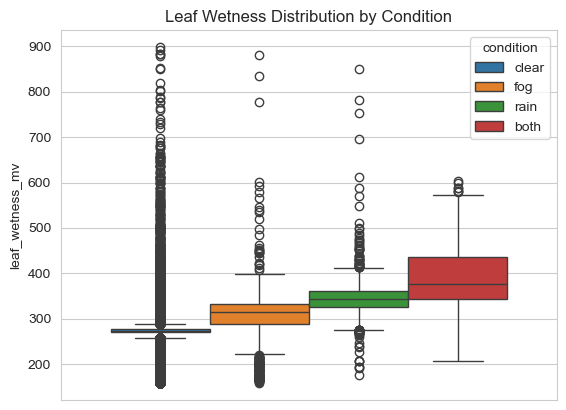

In [17]:
# Leaf wetness boxplot
fig, ax = plt.subplots()
sns.boxplot(data=df_og,
            y='leaf_wetness_mv',
            hue='condition')
plt.title('Leaf Wetness Distribution by Condition')
plt.show()

## Create transition variable

In [18]:
# Define transition points between states
df = df_og.copy()

df['transition'] = False
transition_list = df['transition'].copy()
state = df['condition'].iloc[0]
for i, row in df.iterrows():
    if row['condition'] != state:
        state = row['condition']
        transition_list[i] = True

df['transition'] = transition_list
df.set_index('time', inplace=True, drop=False)

## Time series plots

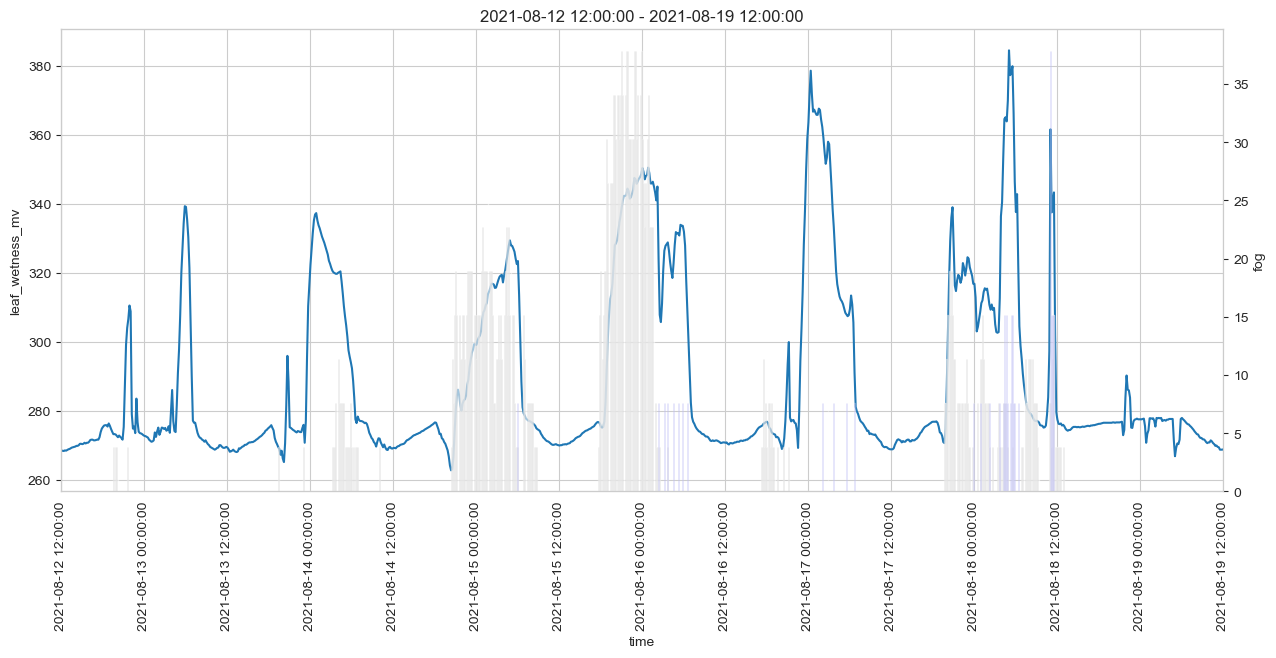

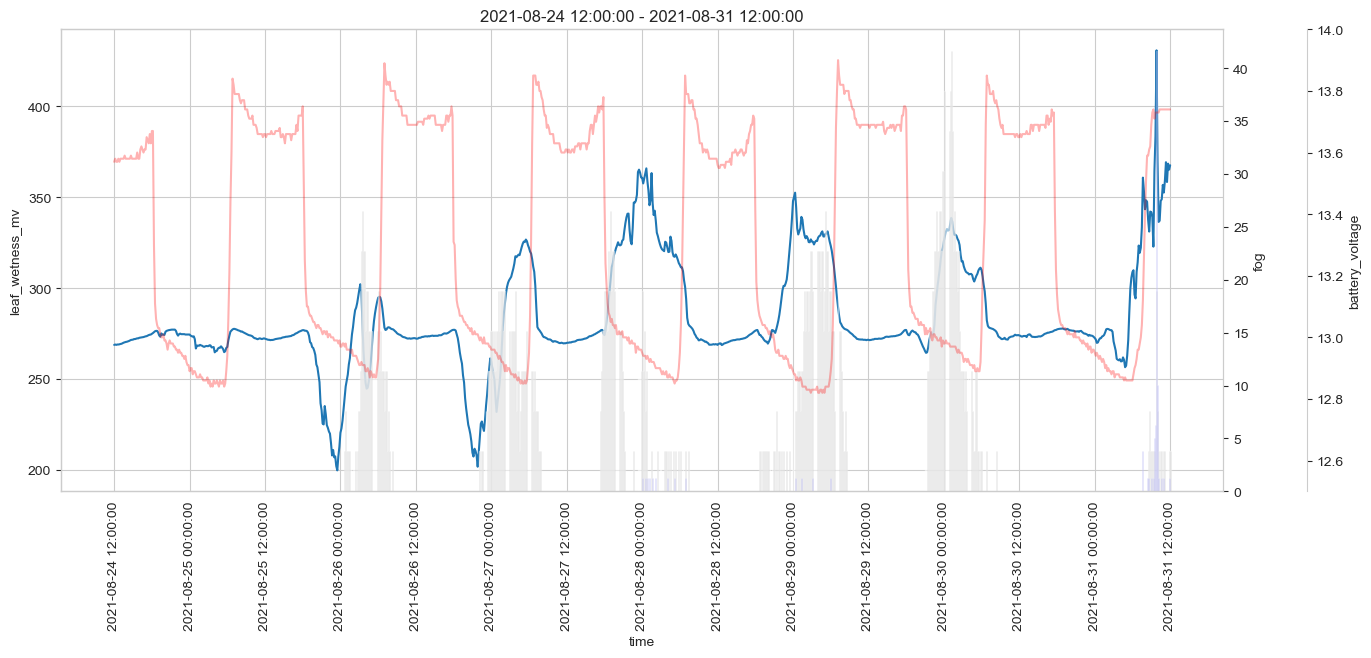

(<Figure size 1500x600 with 4 Axes>,
 <Axes: xlabel='time', ylabel='leaf_wetness_mv'>)

In [19]:
# Plot Fog Event Examples
fog_event = df['2021-08-12 12:00:00': '2021-08-19 12:00:00']
fog_event_2 = df['2021-08-24 12:00:00' : '2021-08-31 12:00:00']

leaf_wetness_plot(fog_event, xtick_interval=6*12, show_voltage=False)
leaf_wetness_plot(fog_event_2, xtick_interval=6*12, show_voltage=True)

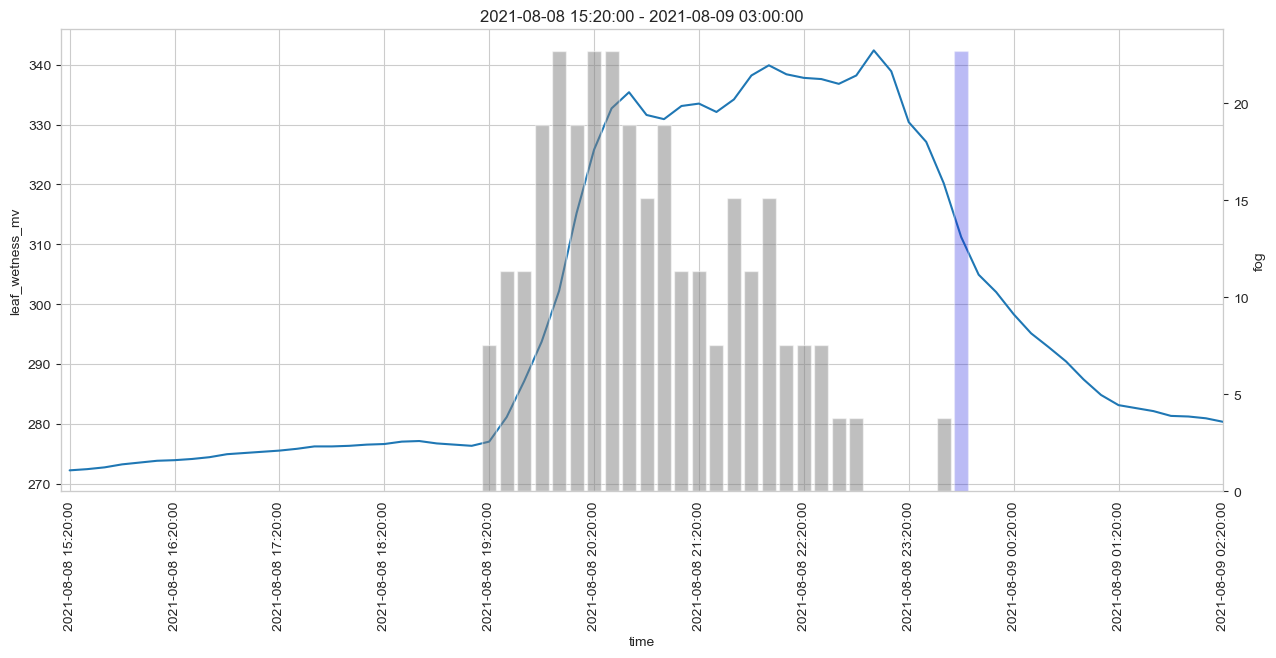

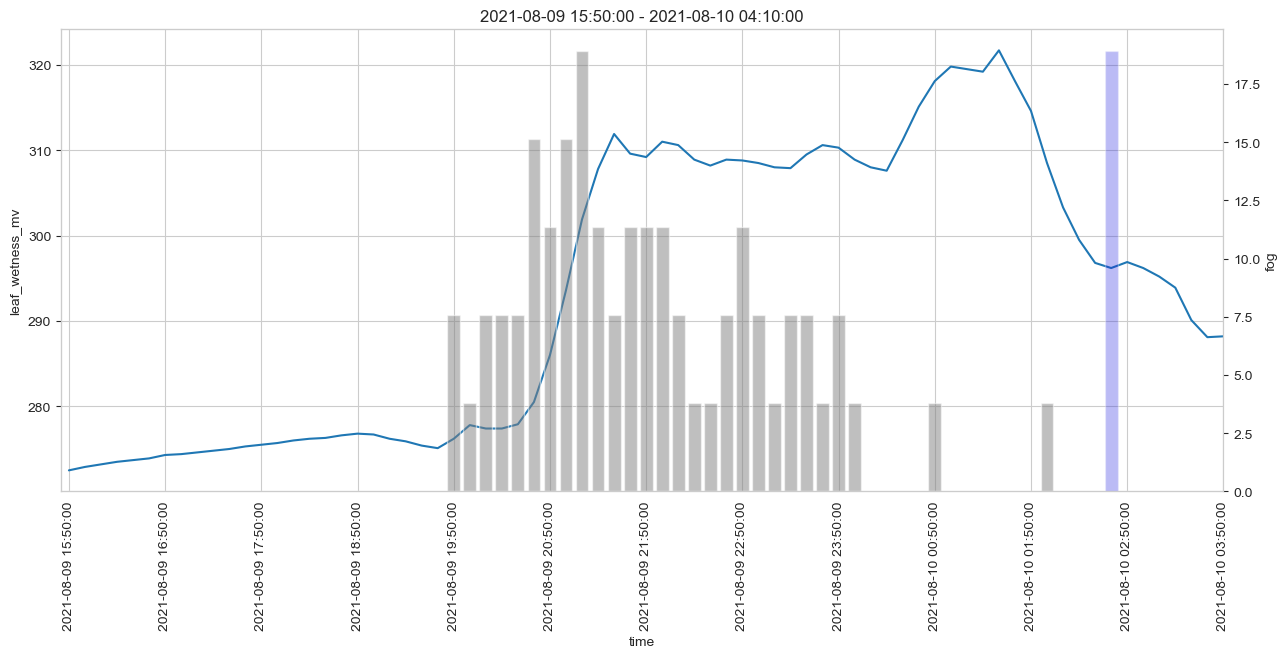

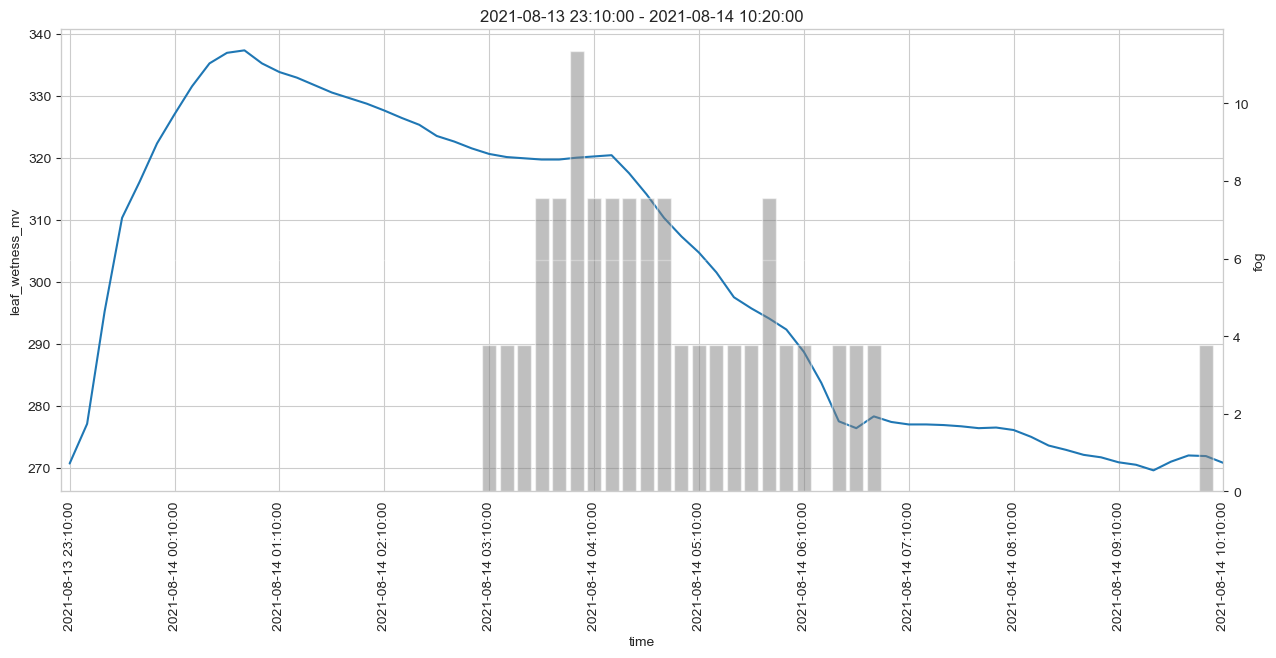

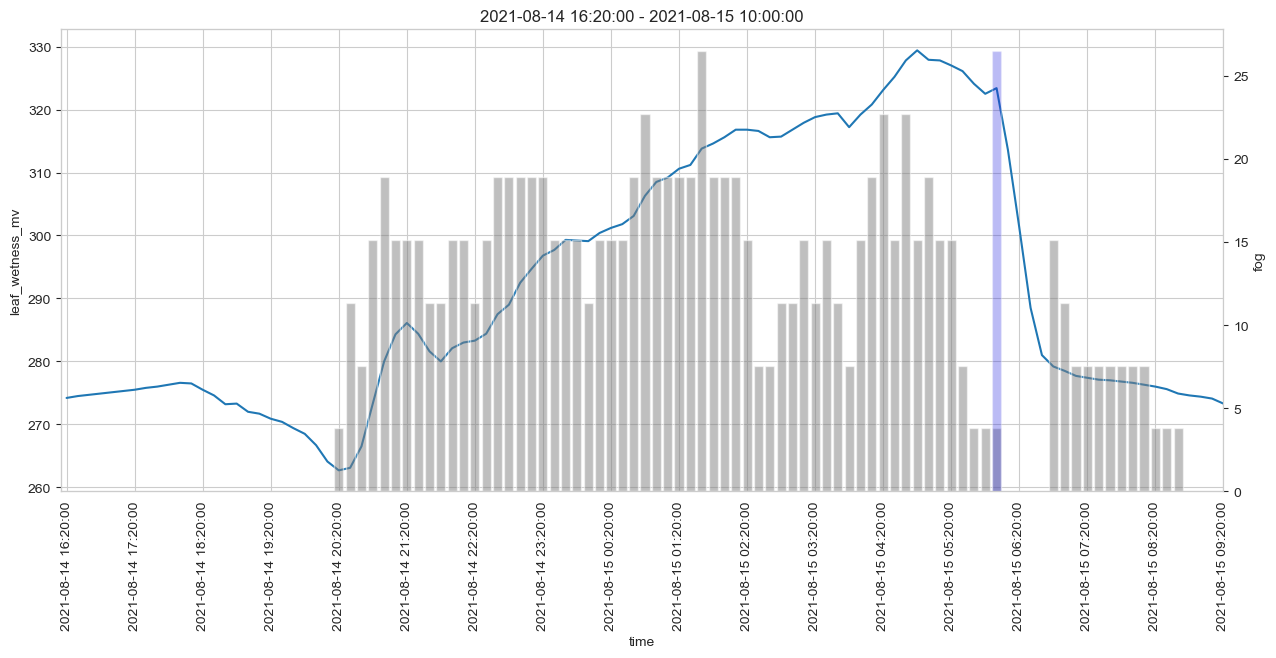

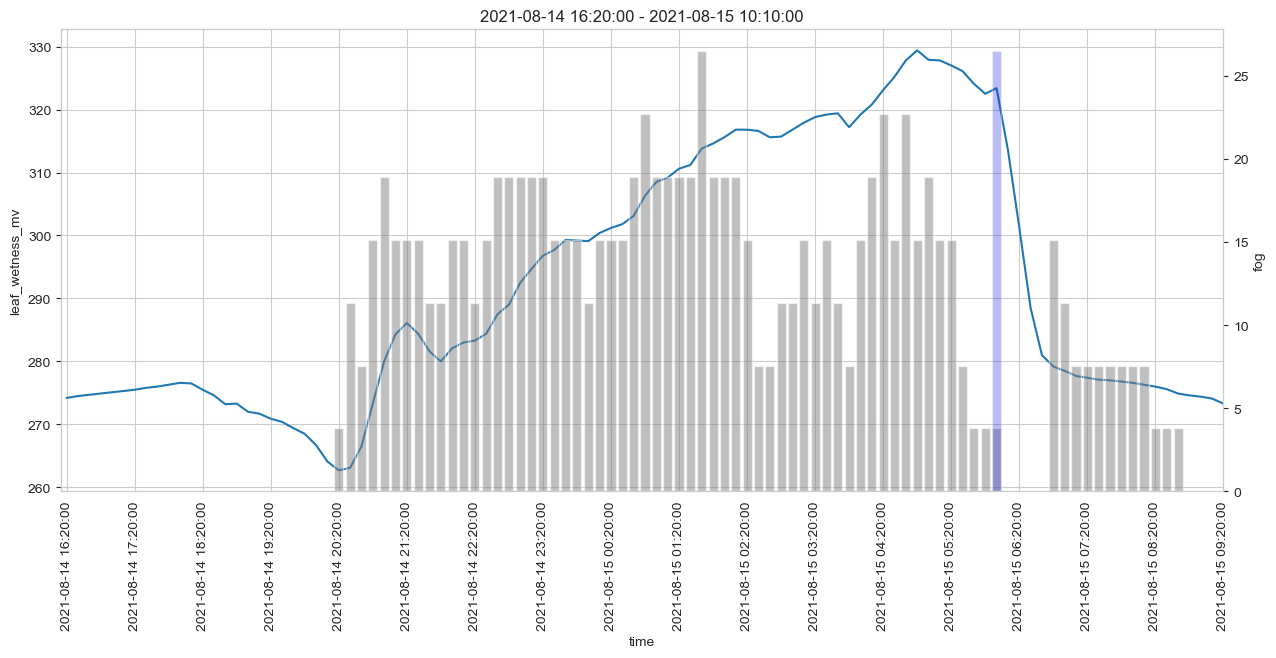

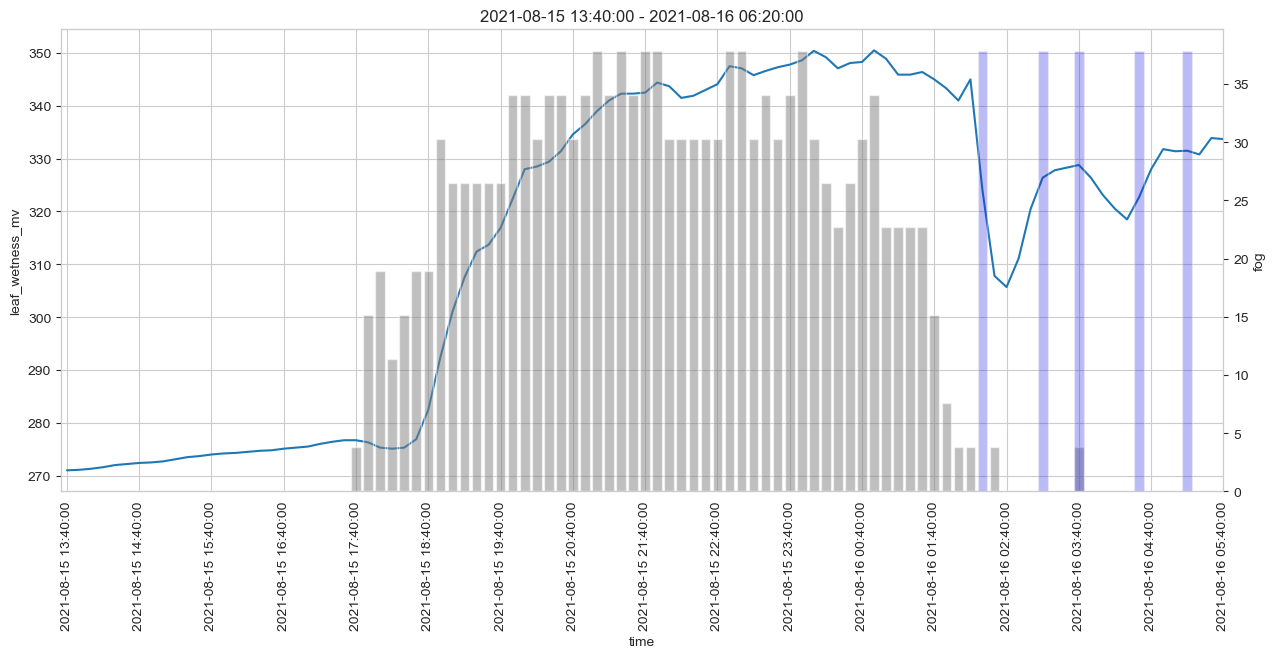

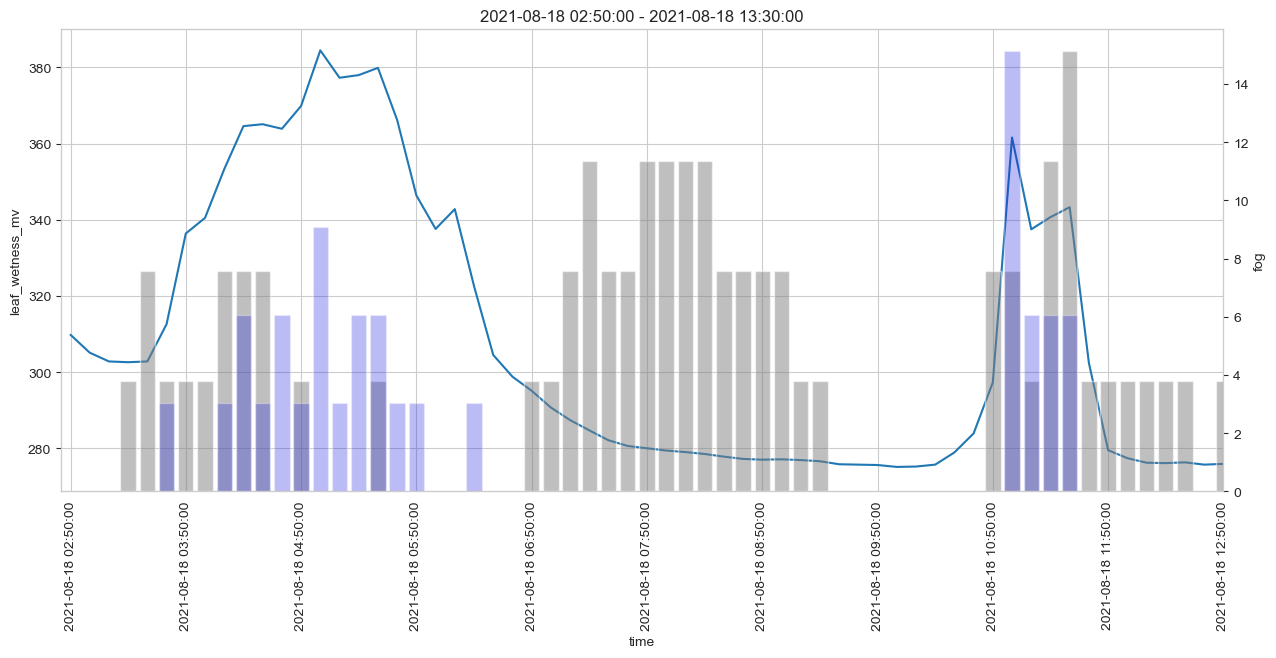

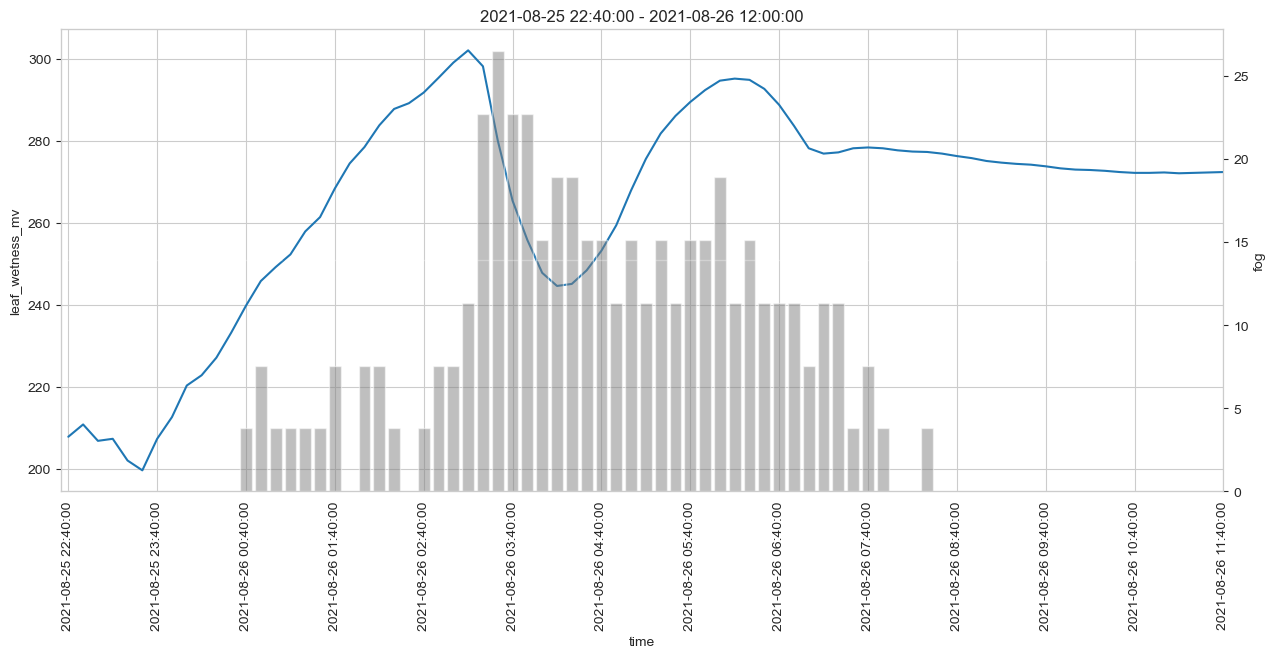

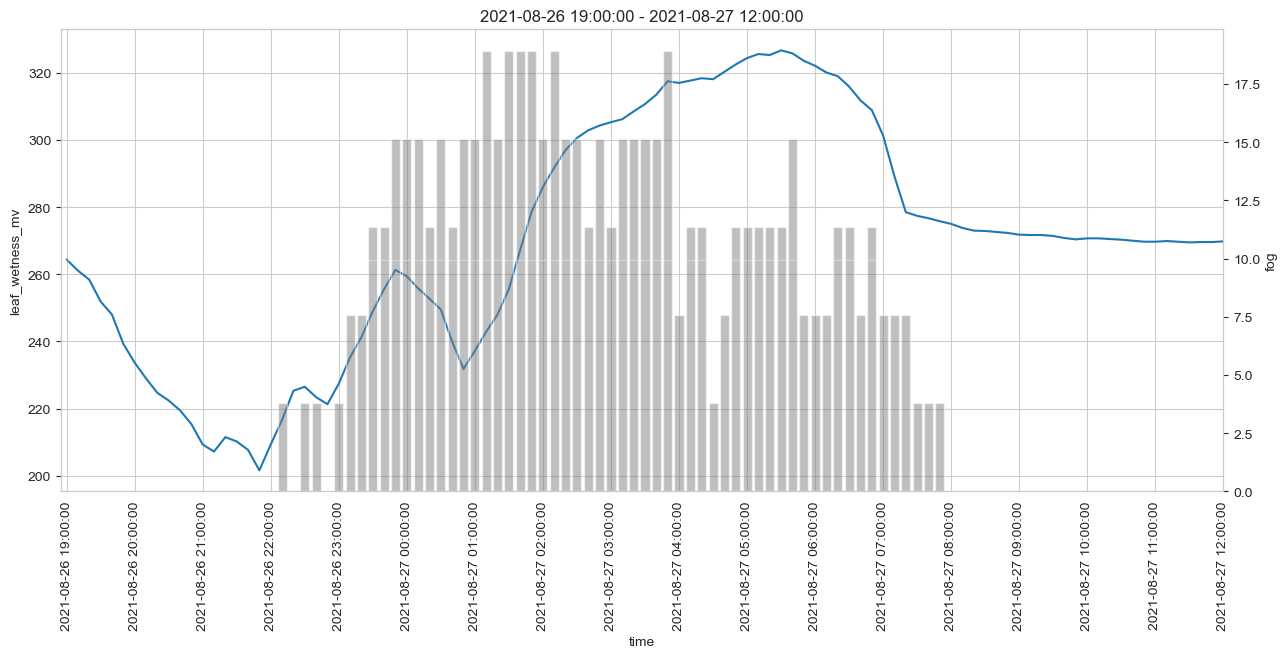

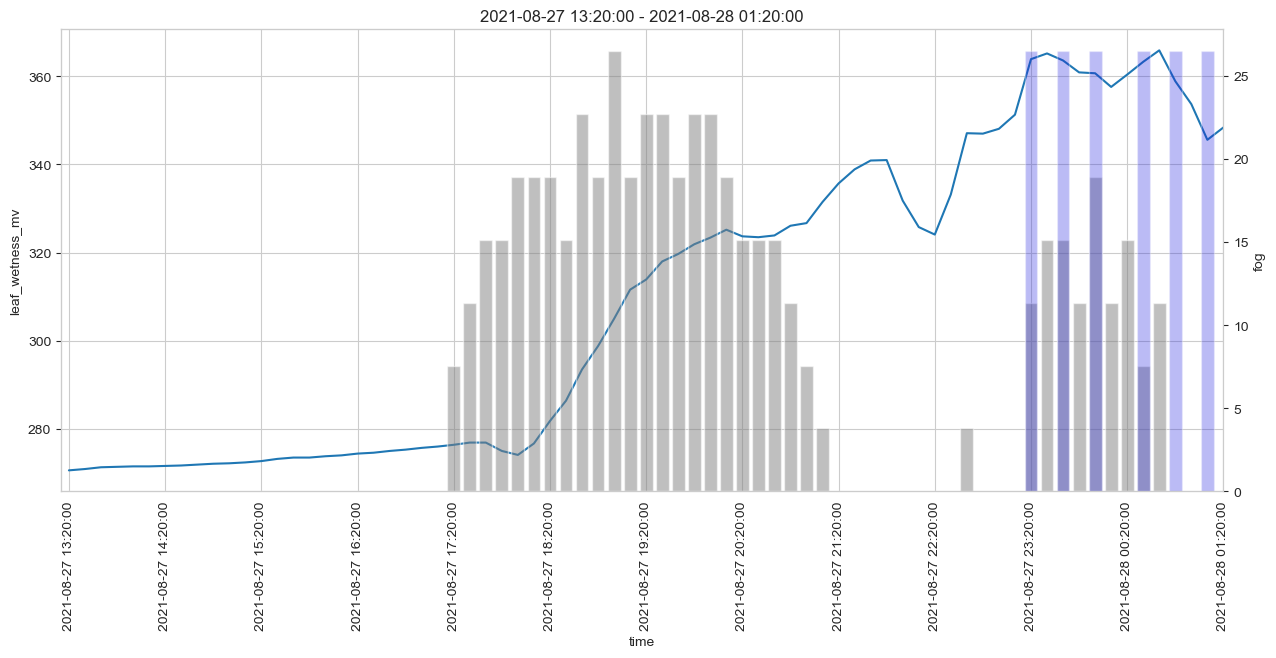

In [20]:
# Plot random subset of fog events
random.seed(1234)
fog_events = find_fog_events(df)
fog_events_subset = random.sample(fog_events, 10)

for event in fog_events[0:10]:
    start_time = str(event[0])
    stop_time = str(event[1])

    event_df = df[start_time:stop_time]

    leaf_wetness_plot(event_df, show_voltage=False)

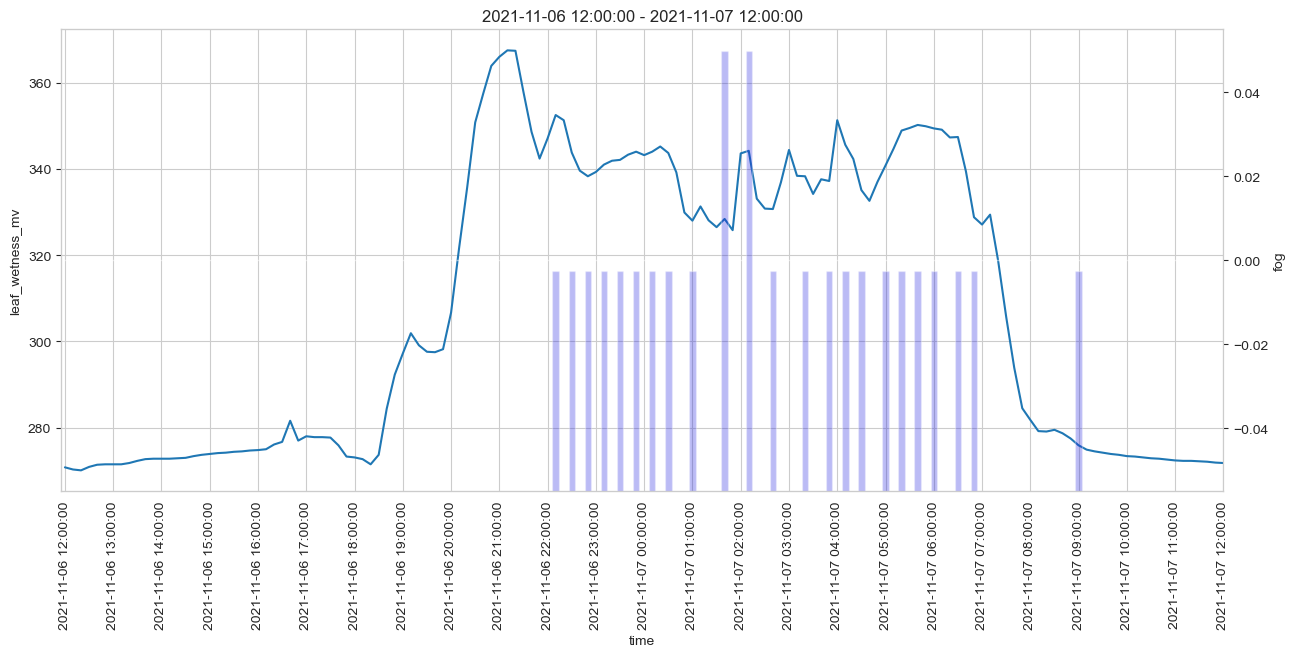

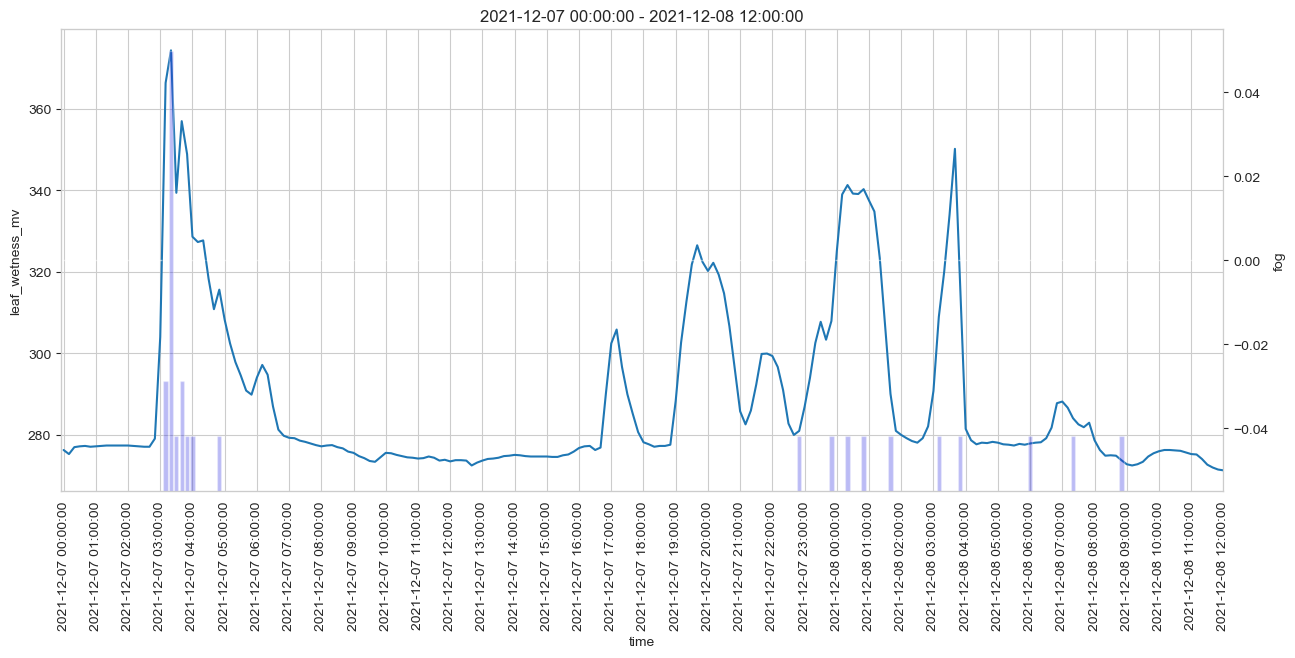

(<Figure size 1500x600 with 3 Axes>,
 <Axes: xlabel='time', ylabel='leaf_wetness_mv'>)

In [21]:
# Check rain events
rain_event_df = df['2021-11-06 12:00:00':'2021-11-07 12:00:00']
rain_event_df_2 = df['2021-12-07 00:00:00': '2021-12-08 12:00:00']
leaf_wetness_plot(rain_event_df, show_voltage=False)
leaf_wetness_plot(rain_event_df_2, show_voltage=False)

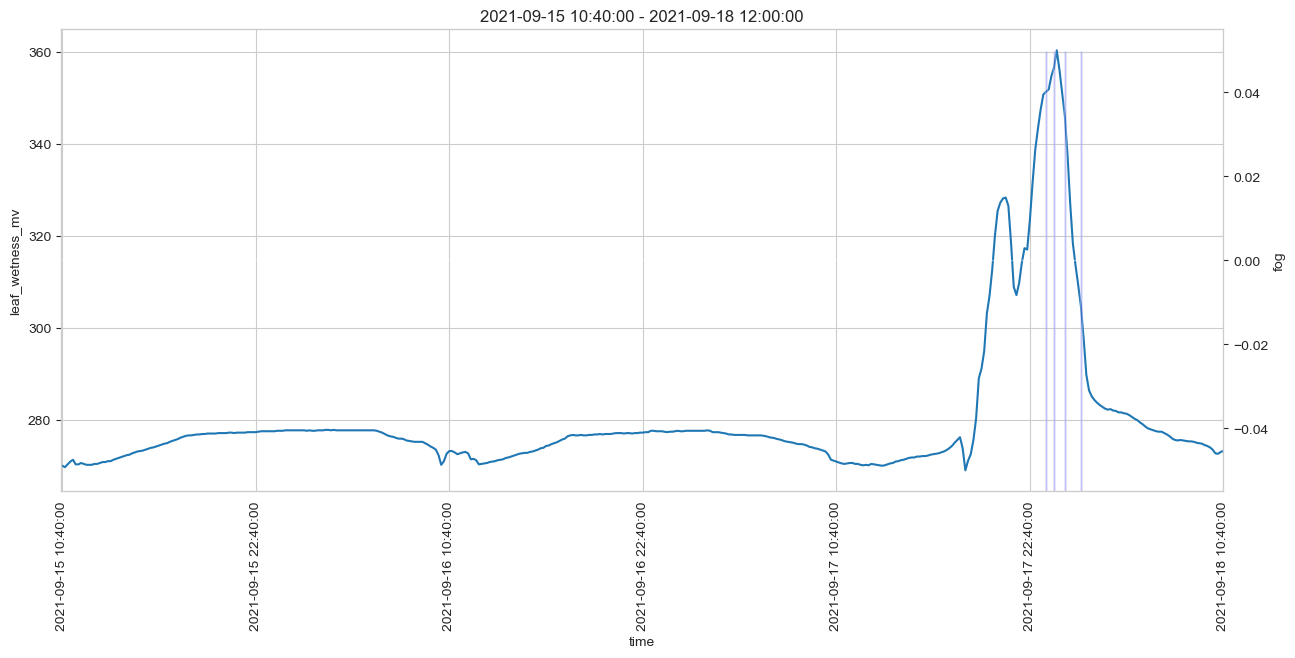

(<Figure size 1500x600 with 3 Axes>,
 <Axes: xlabel='time', ylabel='leaf_wetness_mv'>)

In [22]:
dry_period = df['2021-09-15 10:40:00' : '2021-09-18 12:00:00']
leaf_wetness_plot(dry_period, xtick_interval=6*12, show_voltage=False)
